In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [23]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()
recent_date

('2017-08-23',)

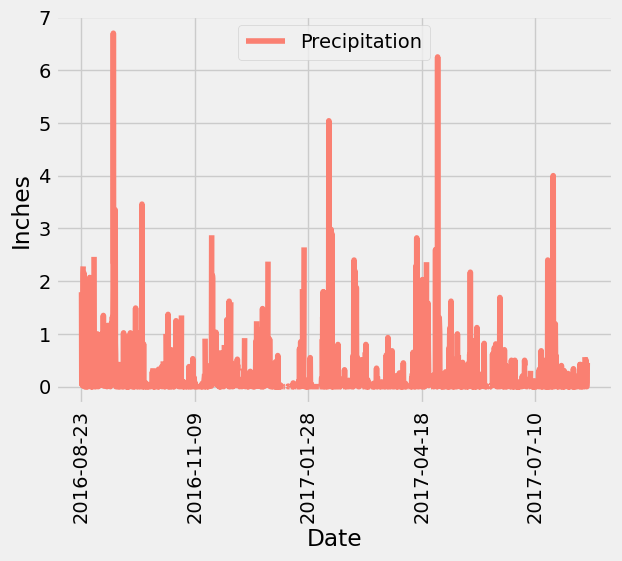

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precip = pd.DataFrame(scores, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date
df_precip = df_precip.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data

df_precip.plot(x = 'Date', y = 'Precipitation', rot=90, color="salmon")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_count = session.query(Station.id).count()
print(total_count)

9


In [13]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x28e6c2f5f60>,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

top_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()
top_stations = pd.DataFrame(top_stations, columns = ['station', 'count'])
top_stations = top_stations.sort_values("count", ascending=False)
top_stations

,station,count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lha = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
lha

[(54.0, 85.0, 71.66378066378067)]

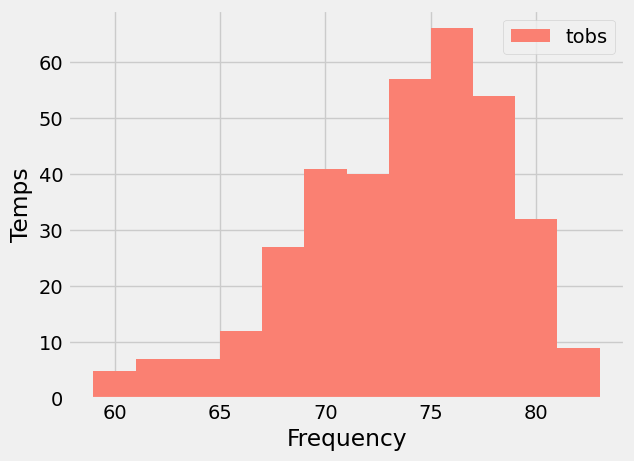

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent = session.query(func.max(Measurement.date)).filter(Measurement.station == 'USC00519281').first()
prev_year = dt.date(2017, 8, 18) - dt.timedelta(days=365)
results = session.query(Measurement.tobs).filter(Measurement.date >= prev_year).filter(Measurement.station == 'USC00519281').all()
df_hist = pd.DataFrame(results, columns = ['Temperature'])

labels = ["tobs"]
plt.hist(df_hist.Temperature, color="salmon", bins = 12)

plt.legend(labels)
plt.xlabel("Frequency")
plt.ylabel("Temps")
plt.show()

In [22]:
measurement_results = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all()
df_measurement = pd.DataFrame(measurement_results)
data_measurement = df_measurement.to_dict(orient="records")
data_measurement

[{'station': 'USC00519397', 'date': '2010-01-01', 'prcp': 0.08, 'tobs': 65.0},
 {'station': 'USC00519397', 'date': '2010-01-02', 'prcp': 0.0, 'tobs': 63.0},
 {'station': 'USC00519397', 'date': '2010-01-03', 'prcp': 0.0, 'tobs': 74.0},
 {'station': 'USC00519397', 'date': '2010-01-04', 'prcp': 0.0, 'tobs': 76.0},
 {'station': 'USC00519397', 'date': '2010-01-06', 'prcp': nan, 'tobs': 73.0},
 {'station': 'USC00519397', 'date': '2010-01-07', 'prcp': 0.06, 'tobs': 70.0},
 {'station': 'USC00519397', 'date': '2010-01-08', 'prcp': 0.0, 'tobs': 64.0},
 {'station': 'USC00519397', 'date': '2010-01-09', 'prcp': 0.0, 'tobs': 68.0},
 {'station': 'USC00519397', 'date': '2010-01-10', 'prcp': 0.0, 'tobs': 73.0},
 {'station': 'USC00519397', 'date': '2010-01-11', 'prcp': 0.01, 'tobs': 64.0},
 {'station': 'USC00519397', 'date': '2010-01-12', 'prcp': 0.0, 'tobs': 61.0},
 {'station': 'USC00519397', 'date': '2010-01-14', 'prcp': 0.0, 'tobs': 66.0},
 {'station': 'USC00519397', 'date': '2010-01-15', 'prcp': 0.0

# Close Session

In [18]:
# Close Session
session.close()
